# Visualization
- CNN 모델의 activation map 시각화 

# 출처
- 부스트캠프 aitech 과제


## Utils (module)

In [1]:
from os import path
import wheel
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable
from torch.autograd import Function
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

import functools
import urllib
import cv2
import numpy as np
import os
import sys
import math
import random
import matplotlib.pyplot as plt
from glob import glob
from scipy.ndimage.filters import gaussian_filter
from IPython.display import clear_output, Image, display, HTML
from google.protobuf import text_format
from io import StringIO

import PIL.Image
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

## Utils (image converter)

In [4]:
def image_tensor_to_numpy(tensor_image):
    # 이미 numpy 이미지라면 바로 return 
    if type(tensor_image) == np.ndarray:
        return tensor_image
    
    # pytorch 0.4 이상 버전에서는 Variable이 deprecated. 혹시나 Variable인 경우 tensor로 변환
    if type(tensor_image) == Variable:
        tensor_image = tensor_image.data
    
    # numpy로 변환하고 필요하다면 CPU로 옮긴다. 
    np_img = tensor_image.detach().cpu().numpy()
    
    # (C,H,W) 에서 batch dimension을 추가해줌. 
    if len(np_img.shape) == 3:
        np_img = np_img[np.newaxis, ...]
    
    # pytorch convention(B,C,H,W)에서 OpenCV/numpy convention(B,H,W,C)으로 
    np_img = np_img.transpose(0, 2, 3, 1)
    
    return np_img

def image_numpy_to_tensor(numpy_image):
    # (H,W,C) 에서 batch dimension을 추가해줌. 
    if len(numpy_image)==3:
        numpy_image = numpy_image[np.newaxis, ...]
        
    #  OpenCV/numpy convention(B,H,W,C)에서 pytorch convention(B,C,H,W)으로 
    numpy_image = numpy_image.transpose(0, 3, 1, 2)
    
    tensor_image = torch.from_numpy(numpy_image).float()
    
    return tensor_image
     

## Utils (image drawer)

In [5]:
def normalize(tensor):
    x = tensor - tensor.min()
    x = x / (x.max() + 1e-9) # 0으로 나누는 것 방지하기 위해 1e-9 더함. 
    return x

def draw_border(image_np, color): # 뭐에쓰는 함수인고..
    color = np.asarray(color)
    s = image_np.shape
    image_np = image_np.copy()
    image_np[0:5, :, :] = color[np.newaxis, np.newaxis, :]
    image_np[:, 0:5, :] = color[np.newaxis, np.newaxis, :]
    image_np[s[0]-5:s[0], :, :] = color[np.newaxis, np.newaxis, :]
    image_np[:, s[0]-5:s[0], :] = color[np.newaxis, np.newaxis, :]
    return image_np

def show_image(image, title=None):
    """
    하나의 이미지를 시각화하는 함수
    - tensor image인 경우 numpy image로 변환
    - H,W,C 값을 정규화
    - 1짜리 차원이 있는 경우 squeeze
    - numpy image 시각화
    """
    np_img = image_tensor_to_numpy(image)
    if len(np_img.shape)>3: # BxHxWxC
        np_img = np_img[0] # HxWxC
    np_img = normalize(np_img)
    
    np_img = np_img.squeeze() # 차원 1짜리가 있는 경우 squeeze 
    plt.figure(figsize=(4,4))
    plt.imshow(np_img)
    plt.axis('off')
    if title: plt.title(title)
    plt.show()
    
def show_images(image_list):
    """
    image_list : 2차원 이미지 리스트????
    """
    for l in image_list:
        f, axarr = plt.subplots(1, len(l))# 이미지 내부에 이미지가 또 여러개? 
        for i, img in enumerate(l):
            np_img = image_tensor_to_numpy(img)
            if len(np_img.shape) > 3: # BxHxWxC
                np_img = np_img[0] # HxWxC
            np_img = normalize(np_img)
            np_img = np_img.squeeze()
            axarr[i].imshow(np_img)
            axarr[i].axis('off')
        plt.show()
        
            

## model definition
- VGG-11 pretrained 불러오고 classification만 학습
- cifar 10 혹은 fashion mnist로 변경

In [104]:
class VGG11BackBone(nn.Module):
    def __init__(self):
        super(VGG11BackBone, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        
        # convolution feature extraction part
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3_1   = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_2   = nn.BatchNorm2d(256)
        self.pool3   = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4_1   = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_2   = nn.BatchNorm2d(512)
        self.pool4   = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_1   = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_2   = nn.BatchNorm2d(512)
        self.pool5   = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = self.conv3_1(x)
        x = self.bn3_1(x)
        x = self.relu(x)
        x = self.conv3_2(x)
        x = self.bn3_2(x)
        x = self.relu(x)
        x = self.pool3(x)

        x = self.conv4_1(x)
        x = self.bn4_1(x)
        x = self.relu(x)
        x = self.conv4_2(x)
        x = self.bn4_2(x)
        x = self.relu(x)
        x = self.pool4(x)

        x = self.conv5_1(x)
        x = self.bn5_1(x)
        x = self.relu(x)
        x = self.conv5_2(x)
        x = self.bn5_2(x)
        x = self.relu(x)
        
        return x
    
class VGG11Classification(nn.Module):
    def __init__(self, num_classes=7):
        super(VGG11Classification, self).__init__()
        
        self.backbone = VGG11BackBone()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc_out = nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.backbone(x)
        x = self.backbone.pool5(x)
        
        x = self.gap(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc_out(x)
        
        return x

In [105]:
model_root = './model.pth'
model = VGG11Classification()

model.load_state_dict(torch.load(model_root))
# 미리 학습되어 저장된 모델(weight) 불러오기
# 참고 : 모델 저장은 torch.save(model.state_dict(), {PATH})
# https://tutorials.pytorch.kr/beginner/saving_loading_models.html


<All keys matched successfully>

## Dataset

In [106]:
class customDataset(Dataset):
    def __init__(self, data_root, input_size=224, transform=None, shuffle=False):
        super(customDataset, self).__init__()
        
        self.img_list = sorted(glob(os.path.join(data_root, '*.jpg')))
        self.len = len(self.img_list)
        self.input_size = input_size
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.img_list[index]
        
        # Image Loading
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # openCV convention(BGR), matplotlib convention(RGB)
        img = img/255.
        
        if self.transform:
            img = self.transform(img)
        return img
    
    def __len__(self):
        return self.len
    

In [107]:
data_root = './data'
input_size = 224

# transform 정의 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                       std=[0.229, 0.224, 0.225]) #ImageNet의 채널별 평균,표준편차 값 이용 
])
dataset = customDataset(data_root, input_size=input_size, transform=transform)

## 1. Visualizing Structure
- 학습된 VGG-11를 visualization


### 과정
- 1.1 각 layer의 weight shape를 확인해보기
- 1.2 총 parameter개수 구하고, torch.summary로 확인
- 1.3 가장 첫번째 conv 레이어의 filter 시각화하기
- 1.4 중간 layer들의 출력값(activation map)을 시각화하기(feat. hook)


### 1.1 각 layer의 weight shape를 확인해보기

In [108]:
for name, module in model.named_parameters():
    names = name.split('.')
    if 'backbone' in name:
        n = names[1]
    else:
        n = name[0]
    if 'weight' in name:
        print(f'** Module {n} **\n'
              f'weights: {module.size()}')

    if 'bias' in name:
        print(f'bias: {module.size()}\n')

** Module conv1 **
weights: torch.Size([64, 3, 3, 3])
bias: torch.Size([64])

** Module bn1 **
weights: torch.Size([64])
bias: torch.Size([64])

** Module conv2 **
weights: torch.Size([128, 64, 3, 3])
bias: torch.Size([128])

** Module bn2 **
weights: torch.Size([128])
bias: torch.Size([128])

** Module conv3_1 **
weights: torch.Size([256, 128, 3, 3])
bias: torch.Size([256])

** Module bn3_1 **
weights: torch.Size([256])
bias: torch.Size([256])

** Module conv3_2 **
weights: torch.Size([256, 256, 3, 3])
bias: torch.Size([256])

** Module bn3_2 **
weights: torch.Size([256])
bias: torch.Size([256])

** Module conv4_1 **
weights: torch.Size([512, 256, 3, 3])
bias: torch.Size([512])

** Module bn4_1 **
weights: torch.Size([512])
bias: torch.Size([512])

** Module conv4_2 **
weights: torch.Size([512, 512, 3, 3])
bias: torch.Size([512])

** Module bn4_2 **
weights: torch.Size([512])
bias: torch.Size([512])

** Module conv5_1 **
weights: torch.Size([512, 512, 3, 3])
bias: torch.Size([512])

*

### 1.2 총 parameter개수 구하고, torch.summary로 확인

In [109]:
from functools import reduce
def get_module_params_num(module):
    param_num = 0
    for _, param in module.named_parameters():
        '''
        # reduce를 이용한 방법
        param_size = reduce(lambda x, y: x*y, param.size())
        param_num += param_size
        '''
        # torch.prod 이용한 방법. 인풋은 Tensor로 변환해줘야함. 
        param_num += torch.prod(torch.tensor(param.shape))
    return param_num

def get_model_params_num(model):
    module_num = 0
    for name, module in model.named_parameters():
        module_num += get_module_params_num(module)
    return module_num

In [110]:
num_params = get_module_params_num(model)
print(f"Number of parameters in customed-VGG11: {num_params}")

Number of parameters in customed-VGG11: 9229575


In [111]:
# !pip install torchsummary

In [112]:
# torchsummary로 확인
from torchsummary import summary
# 다음과 같은 에러가 뜬다면 weight가 gpu에 로딩된 상태기 때문에 모델을 gpu로 올려줘야함.  
# Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same
model.cuda() 
summary(model, (3,224,224)) # input: C,H,W

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
       BatchNorm2d-6        [-1, 128, 112, 112]             256
              ReLU-7        [-1, 128, 112, 112]               0
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         295,168
      BatchNorm2d-10          [-1, 256, 56, 56]             512
             ReLU-11          [-1, 256, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]         590,080
      BatchNorm2d-13          [-1, 256, 56, 56]             512
             ReLU-14          [-1, 256,

### 1.3 가장 첫번째 conv 레이어의 filter 시각화하기
첫번째 conv레이어는 RGB, 즉 3개의 채널 형태의 input image를 받는다. (해당 filter의 입력 채널 수도 이와 동일) 따라서 filter를 RGB image로 변환하여 시각화할 수 있다. 

#### Q. 이후 레이어의 filter들은 시각화하지 않는 이유?
뒤쪽 레이어는 필터 자체의 차원수가 높다 (3채널 칼라로 시각화할 수 있는 형태 아님) 차원수 높다보니 사람이 시각화하여 확인해도 해석 불가.. 그리고 추상적인 합성으로 역할이 결정됨으로 하나의 filter 단독으로 해석하는게 의미 없음. 

In [328]:
def plot_filters(data, title=None):
    '''
    data : tensor filter일 때 (output_channel, input_channel, filter_H, filter_W)
    각각의 (H,W)를 시각화
    예) data = conv1의 filter = model.backbone.conv1.weight(size=64,3,3,3)를 예시로 주석 작성함
    
    plot_filter함수를 activation map 시각화할 떄도 이용할 수 있다. 
    data : activation map일 때는 (batch_size, channel, height, width)
    - torchsummary의 레이어별 output shape참고.
    
    '''
    
    # channel이 3초과일 때, channel을 맨 앞으로 (c,1,h,w)
    if data.size(1) > 3: 
        data = data.view(-1, 1, data.size(2), data.size(3))
    
    # to numpy
    data = image_tensor_to_numpy(data)
    
    # normalize data for display
    data = (data - data.min())/(data.max()-data.min() + 1e-9)
    
    ##### data = conv1의 filter를 예시로 주석 작성
    # n = 8
    n = int(np.ceil(np.sqrt(data.shape[0]))) 
    
    # padding = ((0, 0), (0, 2), (0, 2), (0, 0))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 2), (0, 2))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    # padding 전 filter.shape : (64, 3, 3, 3) 
    # padding 후 filter.shape : (64, 5, 5, 3)
    
    
    # tile the filters into an image
    # data.reshape((0, 2, 1, 3, 4))
    # data.shape : (8, 8, 5, 5, 3) -> (8, 5, 8, 5, 3)
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1))) 

    # data.shape : (8, 5, 8, 5, 3) -> (40,40,3)
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:]) # (40,40,3)
    
    data = data.squeeze() # (40,40,3) -> (40,40,3)

    # plot it 
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.title(title)
    plt.imshow(data)
       

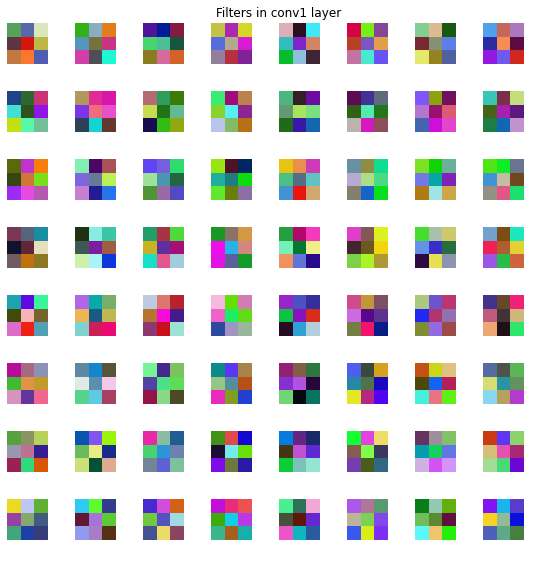

In [329]:
conv1_filters_data = model.backbone.conv1.weight
plot_filters(conv1_filters_data, title="Filters in conv1 layer")


### 1.4 중간 layer들의 출력값(activation map)을 시각화하기(feat. hook)

In [330]:
# activation map 시각화는 filter 시각화와 동일한 함수를 사용
plot_activations = plot_filters

In [331]:
# hook 함수 정의
def show_activations_hook(name, module, input, output):
    if output.dim() == 4: # torchsummary의 output.dim 참고
        plot_activations(output, f'Activations on : {name}')

In [338]:
# img = dataset[0]
# show_image(img)
# img = img[np.newaxis, ...]
# img.shape

In [339]:
model = VGG11Classification()
model.load_state_dict(torch.load(model_root))

module_list = [model.backbone.conv1, model.backbone.bn4_1, model.backbone.conv5_2]
module_names = ['conv1', 'bn4_1', 'conv5_2']
model.double()

from functools import partial

for idx, (name, module) in enumerate(zip(module_names, module_list)):
    hook = partial(show_activations_hook, name) #show_activations에서 name 인자가 들어간 새 함수 정의
    module.register_forward_hook(hook)
 

# _ = model(img)

## 2. Saliency map 시각화

[Saliency map이란?](https://www.geeksforgeeks.org/what-is-saliency-map/)  CNN이 최종 결과를 내리기까지 input image의 각 pixel이 기여하고 있는 정도를 시각화하는 방법이다. 
saliency map의 밝은 부분은 해당 클래스를 예측하는 데 있어서 큰 영향을 주는 부분임을 나타낸다. (히트맵과 유사)

아래 코드에서 계산하고자 하는 gradient 식은 다음과 같다. 
$${\partial s_y \over \partial I}$$


$s_y$는 class $y$에 대한 logit을(=fully connected layer를 통과하고 softmax layer를 통과하기 이전의 값), $I$는 input image를 나타낸다. 

- 논문의 section 3.1, section 2 를 참고
- [논문 링크](https://arxiv.org/pdf/1312.6034.pdf)
- 추가
    - cam과 saliency map의 차이점은?
    - cam은 gap레이어가 있어, 백본의 마지막 피쳐맵의 각 픽셀이 최종 클래스 예측에 미치는 영향을 시각화한다면, saliency map은 특정 클래스에 대해  input image의 각 픽셀이 미치는 영향을 시각화한 방법이다. (좀더생각..)

In [334]:
def compute_gradient_score(scores, image, class_idx):
    """
    gradient of s_y를 구하는 함수
    - image : requires_grad=True 인 tensor.
    """
    
    grad = torch.zeros_like(image) # input image와 동일한 shape의 tensor 
    
    scores[class_idx].backward() # scores[class_idx] : 특정 class에 대한 logit값

    grad = image.grad 
    assert tuple(grad.shape) == (1,3,224,224) 
    
    return grad[0]

In [335]:
def visualize_saliency(image, model):
    input = torch.tensor(image.unsqueeze(0), requires_grad= True)  # input : (3,224,224) -> (1,3,224,224)
    output = model(input)[0] # output : (1,7)-> (7)로 
    max_score, max_idx = torch.max(output, 0)
    
    grad = compute_gradient_score(output, input, max_idx)
    vis = grad ** 2 # grad가 +든, -든 얼마나 영향있는지 크기가 궁금함.  
    vis, _ = torch.max(vis, 0) # 224*224 각 픽셀마다 3 채널 중 가장 큰 grad값
    return vis

In [340]:
model = VGG11Classification()
model.load_state_dict(torch.load(model_root))
model.double()

# 두 개의 이미지 확인.
input_images = []
saliency_maps = []

for _, sample in enumerate(dataset):
    saliency_map = visualize_saliency(sample, model)
    assert list(saliency_map.shape) == [224,224]
    
    saliency_maps.append(saliency_map.unsqueeze(0)) 
    input_images.append(sample)

row_list = list(zip(input_images, saliency_maps)) 
#show_images(row_list)

/opt/conda/envs/detection/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


마스크를 안 쓴 이미지의 saliency map(위)와 비교했을 때, 마스크를 쓴 이미지의 saliency map(아래)에서 마스크 부근의 영역이 밝게 표현됨. input image의 마스크 영역의 픽셀들이 클래스를 예측하는 데 큰 영향을 준다고 판단 가능. 

In [ ]:
# 3. Grad-CAM

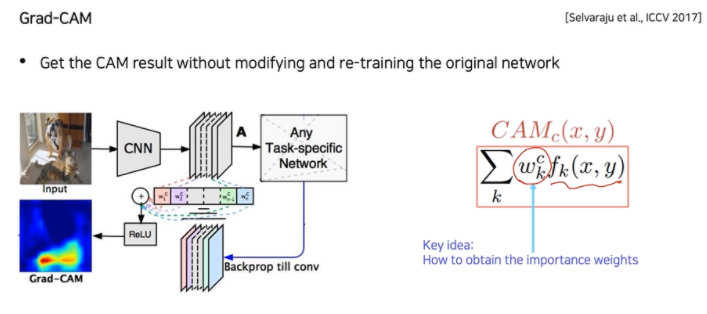

첫번째로 $w_k^c$를 다음 과정으로 계산한다. 
$${\partial y^c \over \partial A^k}$$